In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "./data/" # Define data path

In [2]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame
# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


In [3]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

In [4]:
df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

In [5]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)



In [6]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [7]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

In [8]:
y_predictions_cummulative = None
y_true_cummulative = None
cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary
    
    y_pred = results.predict(X_test) # Run model on test data
    
    if y_predictions_cummulative is None:
        y_predictions_cummulative = y_pred
        y_true_cummulative = y_val
    else:
        y_predictions_cummulative = y_predictions_cummulative.append(y_pred)
        y_true_cummulative = y_true_cummulative.append(y_val)
    
    
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          4.40e-196
Time:                        10:00:32   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:35: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_predictions_cummulative = y_predictions_cummulative.append(y_pred)
C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_true_cummulative = y_true_cummulative.append(y_val)
C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:35: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_predictions_cummulative = y_predictions_cummulative.append(y_pred)
C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     473.3
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:00:32   Log-Likelihood:                -1608.1
No. Observations:                2808   AIC:                             3238.
Df Residuals:                    2797   BIC:                             3303.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4412 

C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:35: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_predictions_cummulative = y_predictions_cummulative.append(y_pred)
C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_true_cummulative = y_true_cummulative.append(y_val)
C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:35: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_predictions_cummulative = y_predictions_cummulative.append(y_pred)
C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2120741595.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [9]:
Comparison_df = y_true_cummulative.join(y_predictions_cummulative.to_frame())
Comparison_df.columns = ['ipc', 'prediction']
Comparison_df['Error'] = (Comparison_df['ipc']-Comparison_df['prediction'])
Comparison_df['SqError'] = Comparison_df['Error']**2
Comparison_df

ipc  prediction     Error   SqError
date       district                                          
2011-04-01 Kapoeta East   2.0    1.974110  0.025890  0.000670
           Kapoeta North  2.0    1.933295  0.066705  0.004450
           Kapoeta South  2.0    1.975826  0.024174  0.000584
           Koch           2.0    1.875291  0.124709  0.015552
           Lafon          3.0    1.814941  1.185059  1.404365
...                       ...         ...       ...       ...
2020-02-01 Wulu           2.0    2.445159 -0.445159  0.198167
           Yambio         3.0    2.443574  0.556426  0.309610
           Yei            3.0    3.214594 -0.214594  0.046051
           Yirol East     4.0    3.380657  0.619343  0.383586
           Yirol West     3.0    3.397179 -0.397179  0.157751

[8320 rows x 4 columns]

In [10]:
mse_by_district = np.sqrt(Comparison_df.groupby('district')['SqError'].mean()).to_frame()
mse_by_district

,SqError
district,
Abiemnhom,0.791102
Akobo,0.942342
Anzara,0.831064
Aweil Center,0.837709
Aweil East,1.022950
...,...
Wulu,0.998377
Yambio,0.906719
Yei,0.820544


C:\Users\alex4\AppData\Local\Temp\ipykernel_7552\2439791926.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


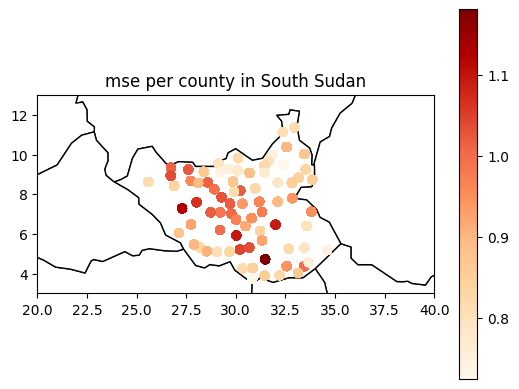

In [25]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Plot mean mse per administration on map
gdf.merge(mse_by_district, on="district").plot(
    column="SqError", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("mse per county in South Sudan");

In [12]:
len(mse_by_district)

78

In [13]:
def prep_population(a):
    a = a.replace(" ", "")
    a = a.replace(".", "")
    a = int(a)
    return a

In [14]:
population_size = pd.read_csv(data_dir + 'DC3_external_datasets/ssd_2023_population_estimates_data.csv', delimiter=';')[['Admin1','Admin2','Population - 2024']]
population_size = population_size.iloc[:-2]
population_size['Population - 2024'] = population_size['Population - 2024'].apply(prep_population)
population_size

,Admin1,Admin2,Population - 2024
0,Abyei Administrative Area,Abyei Administrative Area,133958
1,Central Equatoria,Juba,690920
2,Central Equatoria,Kajo-keji,86973
3,Central Equatoria,Lainya,82153
4,Central Equatoria,Morobo,39642
...,...,...,...
74,Western Equatoria,Mvolo,65339
75,Western Equatoria,Nagero,26738
76,Western Equatoria,Nzara,69044
77,Western Equatoria,Tambura,59089


In [15]:
set(population_size['Admin2'])-set(mse_by_district.index), set(mse_by_district.index)-set(population_size['Admin2'])

({'Abyei Administrative Area',
  'Aweil Centre',
  'Bor South',
  'Canal/Pigi',
  'Kajo-keji',
  'Longochuk',
  'Luakpiny/Nasir',
  'Nzara',
  'Rumbek Centre'},
 {'Anzara',
  'Aweil Center',
  'Bor',
  'Kajo Keji',
  'Longchuk',
  'Nasir',
  'Pigi',
  'Rumbek Center'})

In [16]:
from collections import defaultdict

Name_adaption = defaultdict()
Name_adaption['Aweil Centre'] = 'Aweil Center'
Name_adaption['Bor South'] = 'Bor'
Name_adaption['Canal/Pigi'] = 'Pigi'
Name_adaption['Kajo-keji'] = 'Kajo Keji'
Name_adaption['Longochuk'] = 'Longchuk'
Name_adaption['Luakpiny/Nasir'] = 'Nasir'
Name_adaption['Nzara'] = 'Anzara'
Name_adaption['Rumbek Centre'] = 'Rumbek Center'

def Adapt_names(n):
    if n in Name_adaption.keys():
        return Name_adaption[n]
    else:
        return n

print(set(population_size['Admin2'])-set(mse_by_district.index)-set(Name_adaption.keys()))

population_size_adjusted = population_size
population_size_adjusted['Admin2'] = population_size_adjusted['Admin2'].apply(Adapt_names)
population_size_adjusted = population_size_adjusted.set_index('Admin2')
population_size_adjusted

{'Abyei Administrative Area'}


,Admin1,Population - 2024
Admin2,,
Abyei Administrative Area,Abyei Administrative Area,133958
Juba,Central Equatoria,690920
Kajo Keji,Central Equatoria,86973
Lainya,Central Equatoria,82153
Morobo,Central Equatoria,39642
...,...,...
Mvolo,Western Equatoria,65339
Nagero,Western Equatoria,26738
Anzara,Western Equatoria,69044


In [17]:
Comparison_error_population = mse_by_district.join(population_size_adjusted, how = 'inner')
Comparison_error_population

,SqError,Admin1,Population - 2024
Abiemnhom,0.791102,Unity,40765
Akobo,0.942342,Jonglei,90839
Anzara,0.831064,Western Equatoria,69044
Aweil Center,0.837709,Northern Bahr el Ghazal,124989
Aweil East,1.022950,Northern Bahr el Ghazal,807040
...,...,...,...
Wulu,0.998377,Lakes,69428
Yambio,0.906719,Western Equatoria,138976
Yei,0.820544,Central Equatoria,181841
Yirol East,0.951732,Lakes,136988


0.40034819498280033

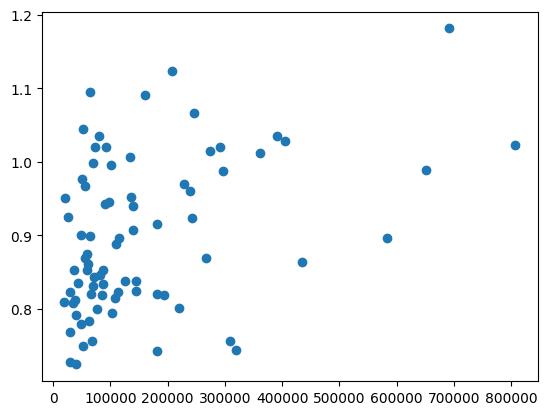

In [18]:
plt.scatter(Comparison_error_population['Population - 2024'],Comparison_error_population['SqError'])
Comparison_error_population['Population - 2024'].corr(Comparison_error_population['SqError'])

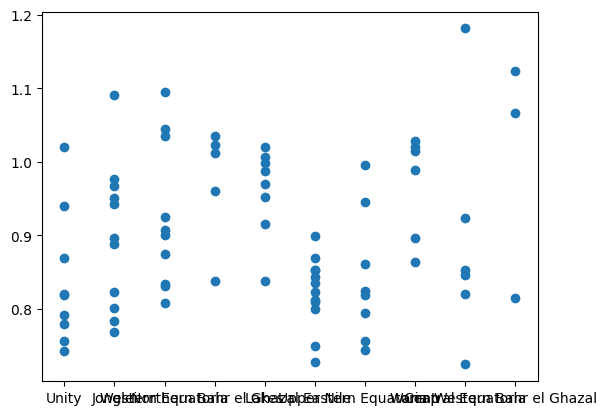

In [19]:
plt.scatter(Comparison_error_population['Admin1'],Comparison_error_population['SqError'])

In [20]:
result_for_report = Comparison_error_population.groupby('Admin1')['SqError'].mean().sort_values(ascending = False).to_frame()
result_for_report

,SqError
Admin1,
Western Bahr el Ghazal,1.001717
Northern Bahr el Ghazal,0.973663
Warrap,0.968587
Lakes,0.960926
Western Equatoria,0.925492
Jonglei,0.898964
Central Equatoria,0.891369
Eastern Equatoria,0.842438
Unity,0.837495


In [21]:
result_for_report.index

Index(['Western Bahr el Ghazal', 'Northern Bahr el Ghazal', 'Warrap', 'Lakes',
       'Western Equatoria', 'Jonglei', 'Central Equatoria',
       'Eastern Equatoria', 'Unity', 'Upper Nile'],
      dtype='object', name='Admin1')

In [22]:
getRegion = dict()
getRegion['Western Bahr el Ghazal'] = 'Bahr el Ghazal'
getRegion['Northern Bahr el Ghazal'] = 'Bahr el Ghazal'
getRegion['Warrap'] = 'Bahr el Ghazal'
getRegion['Western Equatoria'] = 'Equatoria'
getRegion['Lakes'] = 'Bahr el Ghazal'
getRegion['Jonglei'] = 'Greater Upper Nile'
getRegion['Central Equatoria'] = 'Equatoria'
getRegion['Eastern Equatoria'] = 'Equatoria'
getRegion['Unity'] = 'Greater Upper Nile'
getRegion['Upper Nile'] = 'Greater Upper Nile'
assert set(getRegion.keys()) == set(result_for_report.index), "missing states"

In [23]:
result_for_report['Region'] = result_for_report.index
result_for_report['Region'] = result_for_report['Region'].map(getRegion)
result_for_report.index.names = ['State']
result_for_report

,SqError,Region
State,,
Western Bahr el Ghazal,1.001717,Bahr el Ghazal
Northern Bahr el Ghazal,0.973663,Bahr el Ghazal
Warrap,0.968587,Bahr el Ghazal
Lakes,0.960926,Bahr el Ghazal
Western Equatoria,0.925492,Equatoria
Jonglei,0.898964,Greater Upper Nile
Central Equatoria,0.891369,Equatoria
Eastern Equatoria,0.842438,Equatoria
Unity,0.837495,Greater Upper Nile


In [34]:
Comparison_error_population['Region'] = Comparison_error_population['Admin1'].map(getRegion)
Comparison_error_population

,SqError,Admin1,Population - 2024,Region
Abiemnhom,0.791102,Unity,40765,Greater Upper Nile
Akobo,0.942342,Jonglei,90839,Greater Upper Nile
Anzara,0.831064,Western Equatoria,69044,Equatoria
Aweil Center,0.837709,Northern Bahr el Ghazal,124989,Bahr el Ghazal
Aweil East,1.022950,Northern Bahr el Ghazal,807040,Bahr el Ghazal
...,...,...,...,...
Wulu,0.998377,Lakes,69428,Bahr el Ghazal
Yambio,0.906719,Western Equatoria,138976,Equatoria
Yei,0.820544,Central Equatoria,181841,Equatoria
Yirol East,0.951732,Lakes,136988,Bahr el Ghazal


In [35]:
Error_per_region = Comparison_error_population.groupby('Region')['SqError'].mean().to_frame()
Error_per_region.rename(columns = {'SqError': 'MSE'})
Error_per_region

,SqError
Region,
Bahr el Ghazal,0.971472
Equatoria,0.889276
Greater Upper Nile,0.853114
